# Using clustering algorithm to group articles by an author

In [ ]:
import glob, os
import matplotlib.pyplot as plt
import pandas as pd
import numpy

folders = ["AaronPressman", "DavidLawder"]

def makeDataFrame(folders, test = False):
  df = pd.DataFrame() 
  df["author"] = None
  df["text"] = None

  for folder in folders:
    
    if test:
          os.chdir(f'/content/test/{folder}')
    else:
      os.chdir(f'/content/{folder}')

    for file in glob.glob("*.txt"):
      with open(file) as f:
        lines = f.readlines()[:-1]
        text = ' '.join(lines).replace("\n", " ")
        df = df.append({ 'author': folders.index(folder), 'text': text}, ignore_index=True)

  k_true = len(df.author.unique())

  return [df, k_true]

df, k_true = makeDataFrame(folders)

df = df.sample(frac=1)

## Introduction

The dataset: https://archive.ics.uci.edu/ml/datasets/Reuter_50_50

The dataset contains two sets: one for testing and one for training.

Each set has 50 samples per author. The data is given in .txt files. Files are grouped in catalogues by author name. We create the DataFrame by loading every file and labeling it in accordance to the catalog.

The problem is: given the authors' articles, let's forget that we have labels. It is possible to accurately cluster the articles between its authors?

I decided to merge the training sets and test sets because we can evaluate the algorithm's perfomance on the same dataset. We are not conducting classification, but clustering.

## Model creation
### Clustering two authors
At first, we will use the K-Means clustering algorithm to cluster only two authors.

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()

def process(text):
    content = re.sub(r'\d+', '', text)
    content = re.sub('[0-9]+', '', content)
    content = re.sub('\s+', ' ', content).strip()

    sentences = nltk.sent_tokenize(content)

    article = []
    for sentence in sentences:
        words = nltk.word_tokenize(sentence)
        #words = [w for w in words if w not in stopwords.words("english")]
        lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in words if ' ' not in w])
        output = re.sub(' +', ' ', lemmatized_output)
        article.append(output)

    return ''.join(article)

df['text_post'] = df['text'].apply(process)
df['text_post'] = df['text_post'].map(lambda x: re.sub("[,\.`'!?]", '', x))
df['text_post'] = df['text_post'].map(lambda x: x.lower())



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df.iloc[0]['text_post']

'with a contentious  -day strike by the canadian auto workers now behind it  general motors corp could reach a us labor agreement with the united auto workers in a matter of day  union official said wednesday the uaw talk  which affect some  hourly worker  were moving quickly when the strike in canada started on october and stole the spotlight  i think without question they would have settled by now  but the uaw did not want to undermine the canadian union s negotiating stance   said harley shaiken  a professor of labor relation at the university of california-berkeley  the ( uaw ) negotiation will move very quickly  uaw president stephen yokich remains directly involved in the talk  and major unresolved issue are much the same a those that sparked the walkout in canada : the shifting of work to outside supplier  the sale of several part plant and the uaw s demand for job guarantee for percent of gm s worker sources close to the talk said they believe gm will agree to guarantee job for

#### Vectorization

We let the TfidfVectorizer to create (1, 3) (min, max) n-grams. (1, 3) means it will create uni-grams, bi-grams and tri-grams. We also remove stop words. The text was preprocessed in order to remove numbers and special characters.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
  analyzer="word",
  max_df=0.5,
  min_df=2,
  ngram_range=(1, 3),
  use_idf=True,
  stop_words=stopwords.words("english")
)

X = vectorizer.fit_transform(df.text_post)

len(vectorizer.get_feature_names_out())

13447

#### Top 200 words sorted by TF-IDF weights

In [ ]:
zipped = list(zip(vectorizer.get_feature_names_out(), numpy.squeeze(numpy.asarray(X.sum(axis=0)))))

sorted(zipped, key=lambda x: x[1], reverse=True)[:200]

[('gm', 9.245899717097585),
 ('plant', 5.951828529345701),
 ('internet', 4.486140991101501),
 ('uaw', 4.223625137234306),
 ('bank', 3.933769604490321),
 ('worker', 3.551846838476179),
 ('strike', 3.54909653082675),
 ('local', 3.0254967948460587),
 ('union', 2.804125873899907),
 ('automaker', 2.5126834510255898),
 ('truck', 2.344153966782403),
 ('ford', 2.1798347500248356),
 ('million', 2.171973062407798),
 ('contract', 2.0189581144741346),
 ('encryption', 1.9647753471819598),
 ('bill', 1.8743292175953434),
 ('agreement', 1.8605776854312706),
 ('export', 1.8231674777495817),
 ('financial', 1.787721225007226),
 ('three', 1.735692375366942),
 ('chrysler', 1.718820144145141),
 ('percent', 1.7101155640769747),
 ('car', 1.6954035781773515),
 ('congress', 1.6953435487607074),
 ('credit', 1.6826736551490138),
 ('court', 1.671353418419579),
 ('credit union', 1.6591726572555592),
 ('national', 1.647359125092239),
 ('security', 1.6440695617874617),
 ('issue', 1.6291073393736373),
 ('site', 1.6159

#### Visualization of the features

We can use the SVD matrix decomposition in order to reduce the features matrix dimensionality. There is no easy way to plot higher dimensional space, but we can try to reduce it to 2 dimensions in order to get some grasp at the data.

2


Text(0.5, 1.0, '2d features distribution colored by author')

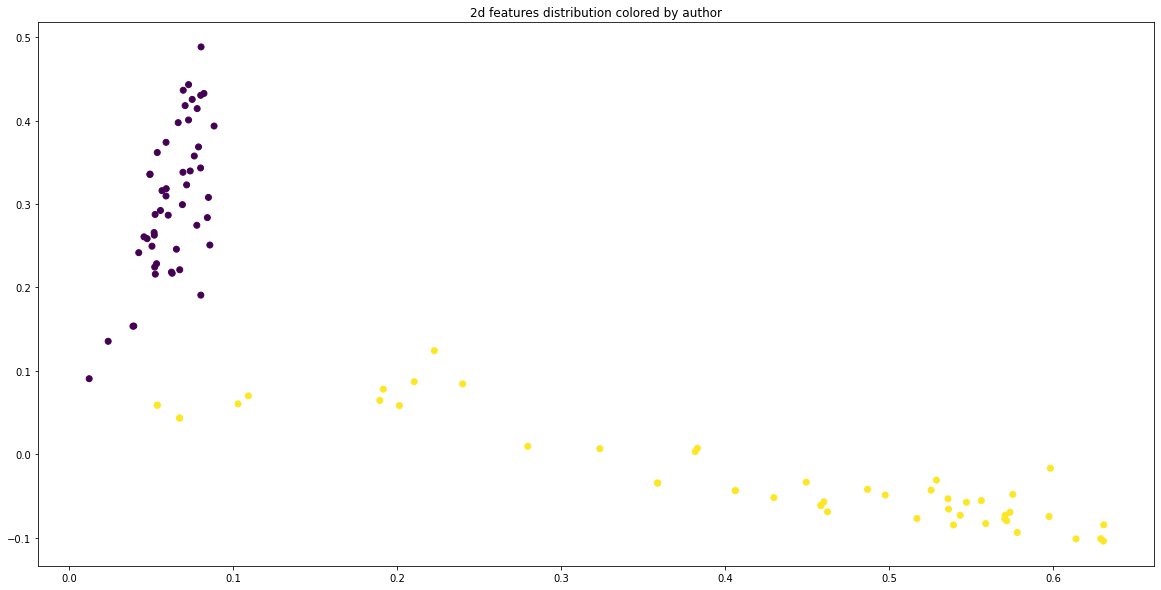

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

svd = TruncatedSVD(2)
#normalizer = Normalizer(copy=False)
#lsa = make_pipeline(svd, normalizer)

X_reduced = svd.fit_transform(X)

x_axis = [o[0] for o in X_reduced]
y_axis = [o[1] for o in X_reduced]

print(len(X_reduced[0])) # x, y 2d
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(x_axis, y_axis, c=df.author)
ax.set_title("2d features distribution colored by author")

In [ ]:
from sklearn.cluster import KMeans, MiniBatchKMeans

km = KMeans(
  n_clusters=k_true,
  init="random",
  max_iter=100,
  n_init=1,
  verbose=True
)

results = km.fit(X)

km.labels_

Initialization complete
Iteration 0, inertia 171.60086632080123
Iteration 1, inertia 87.03762954869492
Iteration 2, inertia 85.79807073917002
Iteration 3, inertia 85.4596511817177
Converged at iteration 3: strict convergence.


array([0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

#### Metrics

Depending on the random initialization, we got v-measure score at range 0.8-1.0 which is pretty good score. However, sillhouete score is low which means clusters overlaps each other.

Parameters for the model were picked by trial and error.

We could use simple accuracy score defined by:
$ \frac{\text{n correct labeled samples}}{\text{total samples}} $

but calculating correct clustered samples needs us to implement own method for counting them since clustering algorithm assigns labels as some permutation of them (i.e. ground truth label 0 becomes 1 and ground truth label 1 becomes 0) so I will use metrics from the ``sklearn`` package.

##### Metrics explained


*   **Completness** -- A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.


*   **Homogenity** -- A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.

* **V-measure** -- is the harmonic mean between homogeneity and completeness. This metric is independent of the absolute values of the labels: a permutation of the class or cluster label values won’t change the score value in any way.

* **Sillhouete score** -- The silhouette value is a measure of how similar an object is to its own cluster compared to other clusters. The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.



In [ ]:
# let's check accuracy

from sklearn.metrics.cluster import completeness_score
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score, rand_score

import numpy 

true = numpy.array(df.author.to_list())
results = km.labels_

completeness_score(true, results), homogeneity_score(true, results), v_measure_score(true, results), silhouette_score(X, km.labels_), adjusted_rand_score(true, results), rand_score(true, results)



(0.7325345894450808,
 0.7249070885783735,
 0.7287008798015752,
 0.06280612279112993,
 0.7721314419105764,
 0.8860606060606061)

In [ ]:
km.cluster_centers_[:,0], km.cluster_centers_[:,1]

(array([0.        , 0.00640659]), array([0.        , 0.00128132]))

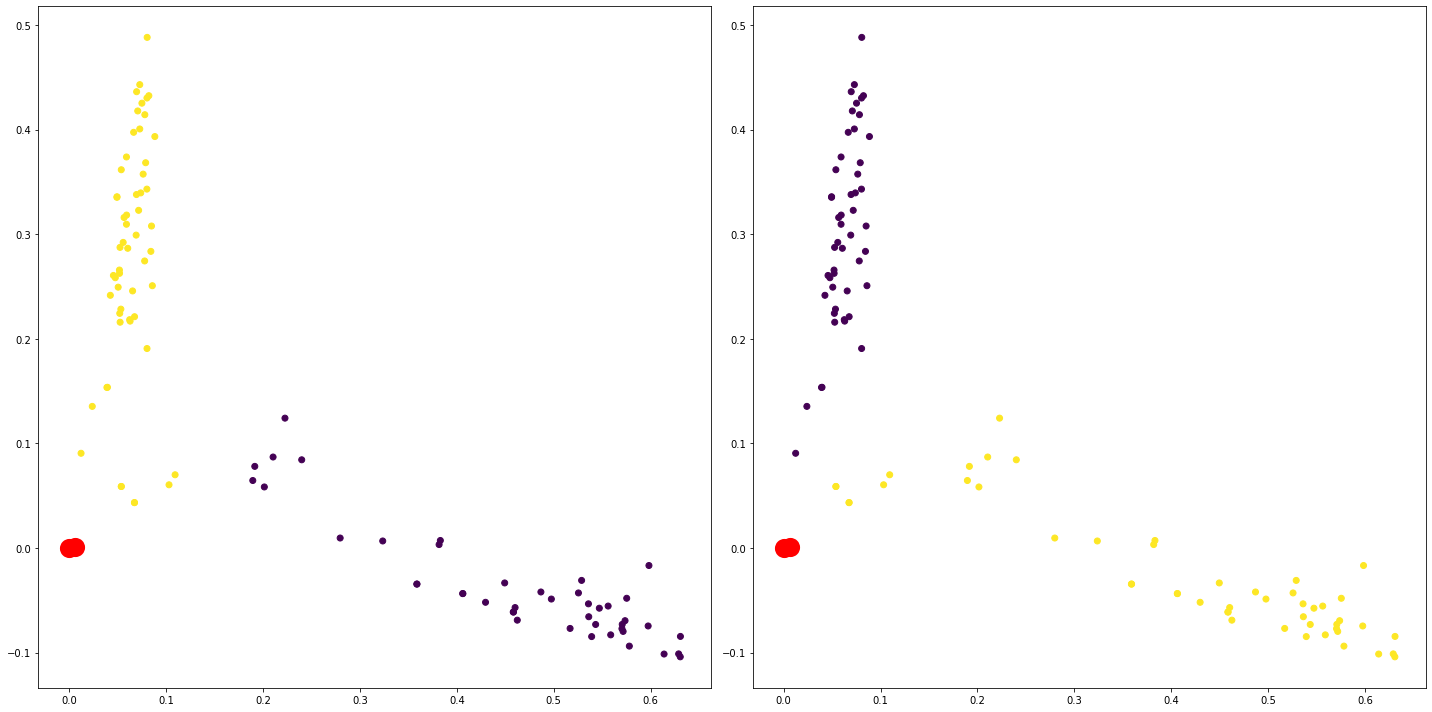

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))

ax[0].scatter(x_axis, y_axis, c=km.labels_)
ax[1].scatter(x_axis, y_axis, c=df.author)
ax[0].scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], zorder=5, linewidth=5, s=200, color='red')
ax[1].scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], zorder=5, linewidth=5, s=200, color='red')

plt.tight_layout()

Centroids seems to be at the same coordinates, however in reality they are in $R^{\text{number of features}}$ space.

### Clustering four authors

#### Data Frame preparation

In [ ]:
folders = ["AaronPressman", "DavidLawder", "LydiaZajc", "NickLouth"]

df, k_true = makeDataFrame(folders)

df = df.sample(frac=1)

df["text_post"] = df["text"].apply(process)

#### Vectorizing

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
  analyzer="word",
  max_df=0.5,
  min_df=2,
  ngram_range=(1, 3),
  use_idf=True,
  stop_words=stopwords.words("english")
)

X = vectorizer.fit_transform(df.text_post)

len(vectorizer.get_feature_names_out())

23464

#### Top 200 words grouped by TF-IDF weights

In [ ]:
zipped = list(zip(vectorizer.get_feature_names_out(), numpy.squeeze(numpy.asarray(X.sum(axis=0)))))

sorted(zipped, key=lambda x: x[1], reverse=True)[:200]

[('gm', 10.621953098852194),
 ('plant', 6.941359434505339),
 ('bank', 6.784881108605959),
 ('stock', 5.785254427358945),
 ('toronto', 5.764758040966327),
 ('internet', 5.345132710086852),
 ('share', 5.312540825924299),
 ('million', 4.9033436013947025),
 ('uaw', 4.735466317424935),
 ('mci', 4.670502825326223),
 ('amp', 4.632927809678768),
 ('gold', 4.550062664293537),
 ('local', 4.3245961869672565),
 ('strike', 4.058236066823085),
 ('worker', 3.95431312399649),
 ('service', 3.7880350647382937),
 ('point', 3.4560101044850327),
 ('canada', 3.3736938767436566),
 ('union', 3.2185579427148014),
 ('million share', 3.14803538724907),
 ('issue', 3.0559488538367776),
 ('automaker', 2.978463879636712),
 ('product', 2.9595651318326084),
 ('quarter', 2.9153290204881985),
 ('canadian', 2.912777485491678),
 ('index', 2.8150604388552654),
 ('key', 2.698387620037641),
 ('truck', 2.6651195039522797),
 ('ford', 2.6071786997265876),
 ('long', 2.60316453453788),
 ('deal', 2.541907031943665),
 ('three', 2.5

#### Visualization of the features

2


Text(0.5, 1.0, '2d features distribution colored by author')

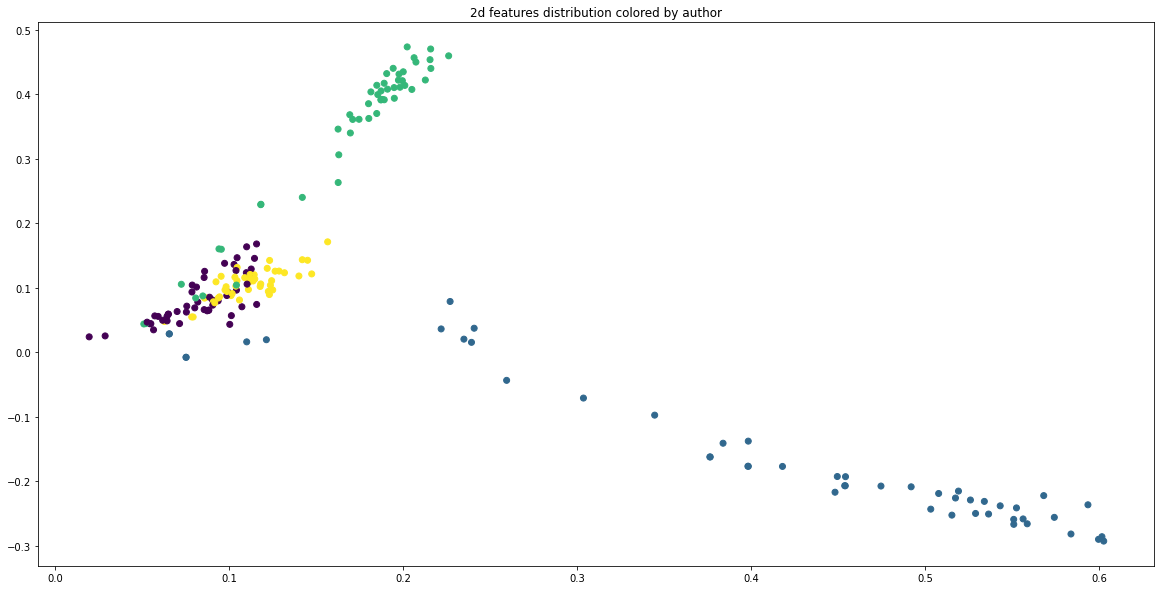

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

# this time we use SVD for training features because perfomance drop is slight but for some reason centroids are better visualized
svd = TruncatedSVD(500)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(X)

svd = TruncatedSVD(2)
X_reduced = svd.fit_transform(X)

x_axis = [o[0] for o in X_reduced]
y_axis = [o[1] for o in X_reduced]

print(len(X_reduced[0])) # x, y 2d
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(x_axis, y_axis, c=df.author)
ax.set_title("2d features distribution colored by author")

#### Fitting

In [ ]:
from sklearn.cluster import KMeans, MiniBatchKMeans

km = KMeans(
  n_clusters=k_true,
  init="k-means++",
  max_iter=100,
  n_init=8,
  verbose=True
)

results = km.fit(X)

km.labels_

Initialization complete
Iteration 0, inertia 330.0414829047863
Iteration 1, inertia 174.07917582751705
Iteration 2, inertia 173.53314389461144
Iteration 3, inertia 173.36938599793842
Iteration 4, inertia 173.2752984758548
Iteration 5, inertia 173.02642396557377
Iteration 6, inertia 172.9385362747417
Iteration 7, inertia 172.9042008446486
Iteration 8, inertia 172.79175865615503
Iteration 9, inertia 172.76466183163583
Converged at iteration 9: strict convergence.
Initialization complete
Iteration 0, inertia 343.7495088188554
Iteration 1, inertia 176.2216492506521
Iteration 2, inertia 174.52001997615005
Iteration 3, inertia 174.31610138279223
Iteration 4, inertia 174.21893405101108
Iteration 5, inertia 174.18673789602414
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 327.0775783764057
Iteration 1, inertia 171.14295074295075
Iteration 2, inertia 170.87302240870085
Iteration 3, inertia 170.2709663106885
Iteration 4, inertia 169.67712004464272
Iter

array([1, 0, 1, 3, 0, 0, 0, 1, 1, 2, 3, 2, 3, 3, 3, 3, 2, 3, 1, 0, 3, 3,
       2, 0, 1, 0, 2, 2, 1, 0, 2, 3, 0, 1, 3, 2, 0, 3, 3, 0, 3, 3, 0, 1,
       0, 3, 2, 2, 3, 1, 3, 1, 2, 1, 3, 1, 1, 3, 0, 0, 0, 0, 0, 3, 2, 1,
       0, 1, 2, 3, 1, 0, 2, 0, 2, 0, 0, 3, 0, 1, 0, 1, 3, 2, 3, 1, 1, 1,
       0, 2, 0, 1, 3, 2, 1, 0, 0, 0, 1, 2, 2, 0, 2, 2, 3, 3, 2, 2, 3, 0,
       1, 3, 1, 1, 0, 2, 3, 3, 3, 3, 0, 0, 2, 3, 3, 1, 0, 1, 0, 0, 0, 1,
       2, 0, 2, 0, 2, 1, 1, 1, 0, 3, 0, 0, 0, 3, 1, 0, 2, 1, 0, 2, 3, 3,
       3, 1, 0, 1, 2, 3, 0, 0, 3, 2, 0, 3, 0, 0, 0, 0, 3, 3, 0, 1, 3, 1,
       3, 2, 1, 3, 3, 3, 3, 2, 0, 3, 2, 0, 0, 0, 3, 3, 2, 1, 2, 1, 3, 0,
       2, 1], dtype=int32)

#### Metrics

In [ ]:
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score, rand_score

import numpy 

true = numpy.array(df.author.to_list())
results = km.labels_

completeness_score(true, results), homogeneity_score(true, results), v_measure_score(true, results), silhouette_score(X, km.labels_)

(0.7607786348379594,
 0.7521032991319736,
 0.7564160934479369,
 0.06141061557985315)

#### Visualization of the fitted clusters

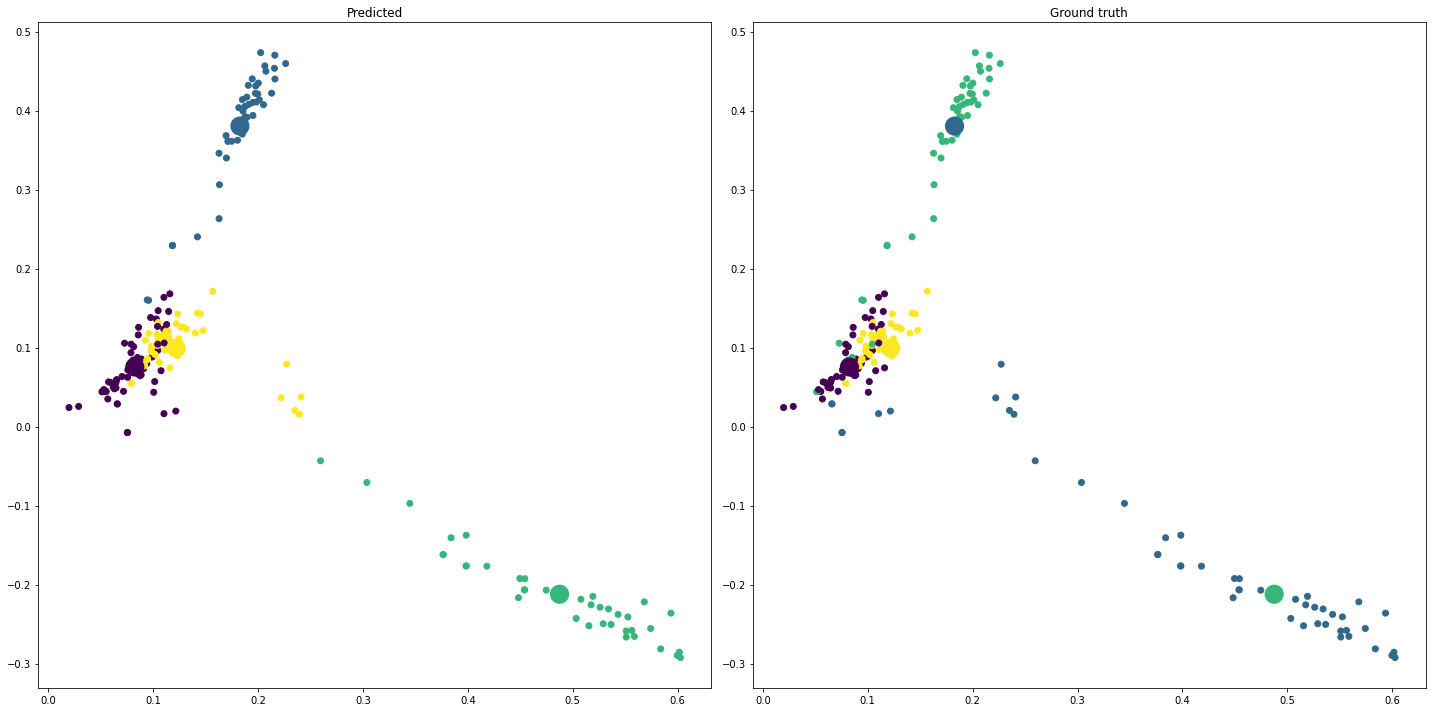

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))

x_axis = [o[0] for o in X_reduced]
y_axis = [o[1] for o in X_reduced]

ax[0].scatter(x_axis, y_axis, c=km.labels_)
ax[0].set_title("Predicted")

# color may be different because labels can be permutted
ax[1].set_title("Ground truth")
ax[1].scatter(x_axis, y_axis, c=df.author)
ax[0].scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], zorder=5, linewidth=5, s=200, c=[0, 1, 2, 3])
ax[1].scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], zorder=5, linewidth=5, s=200, c=[0, 1, 2, 3])

plt.tight_layout()

In [ ]:
df_test, k = makeDataFrame(["LydiaZajc"], test = True)

df_test["text_post"] = df_test["text"].apply(process)

X_test = vectorizer.transform(df_test.text_post)
X_test_reduced = lsa.transform(X_test)

true = numpy.array(df_test.author.to_list())
results = km.predict(lsa.transform(X_test))

completeness_score(true, results), homogeneity_score(true, results), v_measure_score(true, results)

(0.0, 1.0, 0.0)

### Using already fitted clustering for classifying future articles

In [ ]:
X_visualise = svd.transform(X_test_reduced)

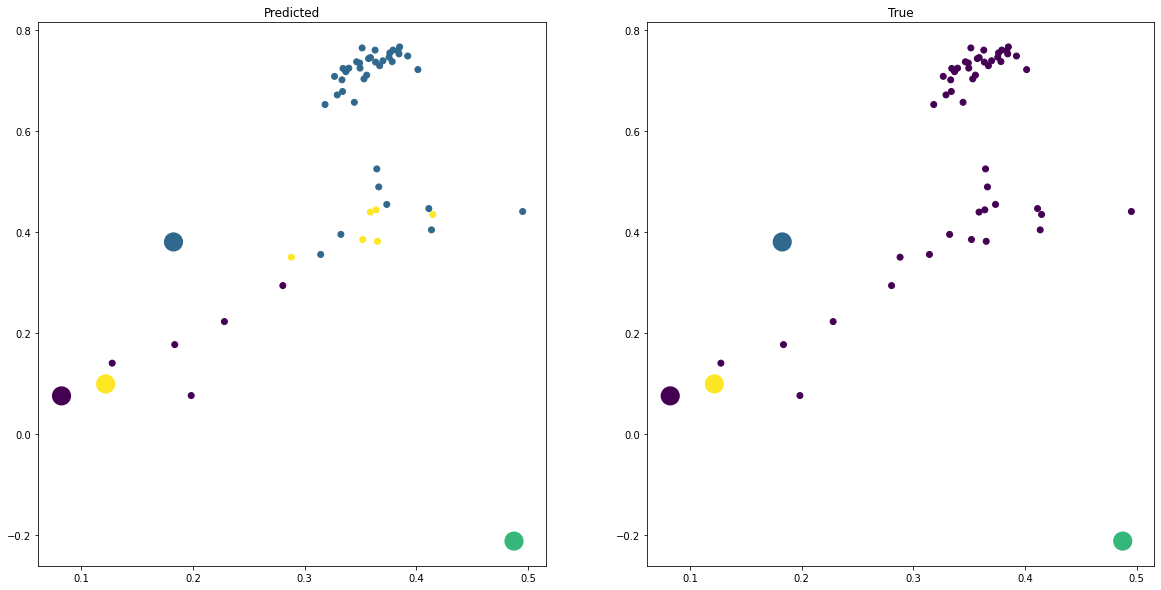

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))

x_axis = [o[0] for o in X_test_reduced]
y_axis = [o[1] for o in X_test_reduced]


## Again, colors may be different because of the label permutation. color order in an array =/= label order 
ax[0].scatter(x_axis, y_axis, c=results)
ax[0].set_title("Predicted")
ax[1].set_title("True")

ax[1].scatter(x_axis, y_axis, c=true)
ax[0].scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], zorder=5, linewidth=5, s=200, c=[0, 1, 2, 3])
ax[1].scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], zorder=5, linewidth=5, s=200, c=[0, 1, 2, 3])

### Conclusion

In this problem, the model works very well for the already existing data. However, if we try to cluster unseen while training data it may be not the best method and it would be better to use other approach.

I also tested Minibatch KMeans algorithm and it works worse than KMeans.

In this problem I think it would be good to merge the training and test datasets. For predicting future data, classification may be better. But since we use clustering, it's not that meangiful to test the model at the test set. Hence, we could merge them.